### Library

* cv2: computer vision library
* matplotlib: plotting library
* lib_detection: library which is used to load model and deliver prediction

In [197]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lib_detection import load_model, detect_lp, im2single

### Load mode

In [186]:
wpod_net_path = "wpod-net_update1.json"
wpod_net = load_model(wpod_net_path)

### Load a test image

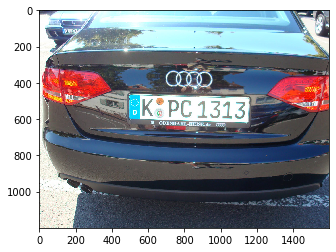

In [187]:
vehicle = plt.imread("test/detection_test.jpg")
plt.imshow(vehicle)

### LpImg variable returned from detect_lp() function is/are the cropped plate image(s= from our vehicle image

In [201]:
Dmax = 608
Dmin = 288

ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
side = int(ratio * Dmin)
bound_dim = min(side, Dmax)

L , LpImg, lp_type = detect_lp(wpod_net, im2single(vehicle), bound_dim, lp_threshold=0.5)
print("Detect %i plate(s)"%len(LpImg))

(24, 32, 8)
Detect 1 plate(s)


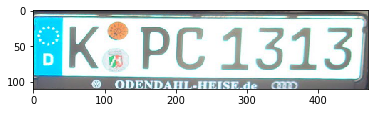

In [172]:
plt.imshow(LpImg[0])

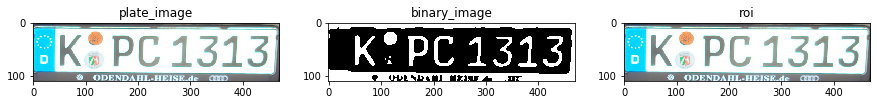

In [106]:
if (len(LpImg)):

    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))

    roi = LpImg[0]

    # convert to grayscale
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(9,9),0)

    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 250, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # plot images
    w,h = 15,8
    fig = plt.figure(figsize=(w,h))
    fig.add_subplot(1,3,1)
    plt.imshow(plate_image)
    plt.title('plate_image')
    
    fig.add_subplot(1,3,2)
    plt.imshow(binary,cmap='gray')
    plt.title('binary_image')
    
    fig.add_subplot(1,3,3)
    plt.imshow(roi,cmap='gray')
    plt.title('roi')  


### Crop the digts using OpenCV techniques

In [36]:
### Create sort_contours() function to grab the contour of each digit
def sort_contours(cnts):

    reverse = False
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    #print(len(cnts))
    return cnts

W0129 00:48:58.791387  8656 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'test_roi')

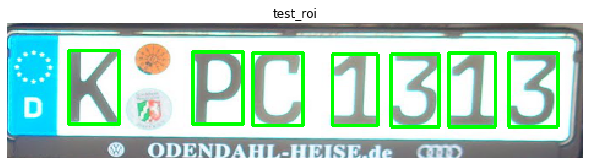

In [213]:
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
cont, _  = cv2.findContours(thre_mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

digit_w = 30
digit_h = 60 

plate_info = ""

# crop 
test_roi = roi.copy()
crop_digits = []

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/roi.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_digits.append(curr_num)

fig = plt.figure(figsize=(8,5))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)      
plt.imshow(test_roi)
plt.title('test_roi')
#plt.savefig('grab_digit_contour.png',dpi=300)


### Load Nvidia model to predict digits

In [38]:
from keras.models import model_from_json
from keras.models import Sequential
model = Sequential()
json_file = open('License_plate_nvidia.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('License_plate_nvidia.h5')

### Create a function that pre-process images and deliver prediction from modle

In [41]:
digit_names = ("0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F",
 "G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V",
 "W","X","Y","Z")

def model_predict(image):
    global digit_names
    import numpy as np
    import cv2
    img = np.asarray(image,dtype=np.float32)
    img = cv2.resize(img,(80,224))
    img = img/255
    img = img[np.newaxis,:]
    if len(img.shape)<4:
        img = np.stack((img,)*3, axis=-1)
    max_value = max((model.predict(img)[0]))
    index = np.where(model.predict(img)[0]==max_value)
    return digit_names[int(index[0])]

### Presenting final results

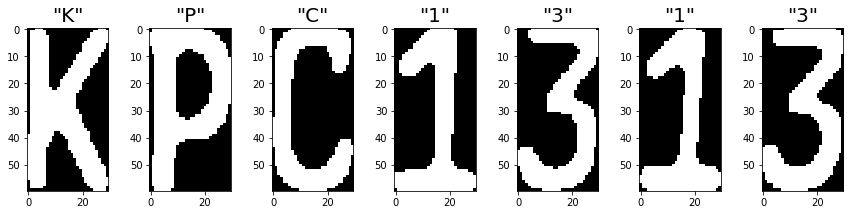

In [209]:
fig = plt.figure(figsize=(15,3))
col = len(crop_digits)
row = 1

final_result = ''

for digit in crop_digits:
    fig.add_subplot(1,col,row)
    title = model_predict(digit)
    final_result+=str(title)
    plt.title('"%s"'%title,fontsize=20)
    plt.imshow(digit,cmap='gray')
    row+=1
plt.savefig('digit_crops.png', dpi=300)

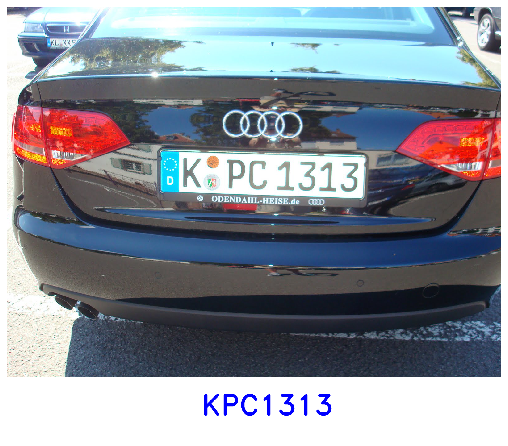

In [207]:
fig = plt.figure(figsize=(10,6))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

final_image = cv2.copyMakeBorder(src=vehicle,top=0,bottom=200,left=0,right=0,
                                  borderType=cv2.BORDER_CONSTANT, value=[255,255,255])
h,w = final_image.shape[:2]
cv2.putText(final_image,final_result,(int(w/2-170),int(h-80)),cv2.FONT_HERSHEY_DUPLEX,3,(0,0,255),5,cv2.LINE_AA)
plt.imshow(final_image)
plt.savefig('vehicle_with_prediction.png', dpi=300)

## THE END!